In [1]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageOps
import numpy as np
from skimage.transform import (hough_line , hough_line_peaks)
from skimage.util import img_as_float
from skimage.util import img_as_ubyte
import numpy.ma as ma

In [2]:
def histogram_stretch(img_in):
    """
    Stretches the histogram of an image
    :param img_in: Input image
    :return: Image, where the histogram is stretched so the min values is 0 and the maximum value 255
    """
    # img_as_float will divide all pixel values with 255.0
    img_float = img_as_float(img_in)
    min_val = img_float.min()
    max_val = img_float.max()
    min_desired = 0.0
    max_desired = 1.0
    img_out = (img_float-min_val)*(1/(max_val-min_val))
    return img_as_ubyte(img_out)
    
def interval_fun (angle,val):
    return (angle>=val-0.05) & (angle<=val+0.05)

detected lines_hor: 1
detected lines_ver: 2
intersection: -58.69810240873176 -21.071350329891857
90.40468366322519 y middle
208.0


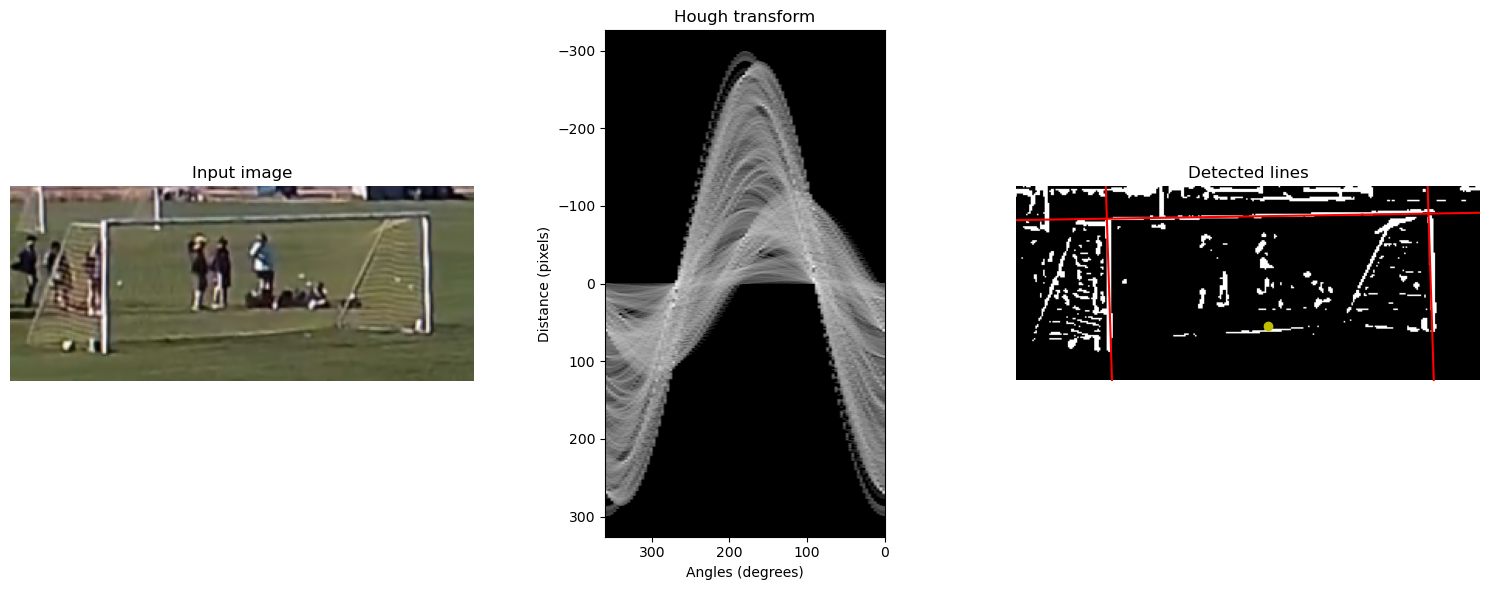

In [3]:

image_org = Image.open("goal2.png")
# image_org = Image.open("6.jpg")
image = image_org.convert("L")
image1 = np.array(image)
image_org_1 = np.array(image_org)
image1 = histogram_stretch(image1)

# ret,image1 = cv2.threshold(image1,220,255,cv2.THRESH_BINARY)
ret, image1 = cv2.threshold(image1,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

tested_angles = np.linspace( 0, 2*np.pi , 100)

hspace, theta, dist = hough_line(image1, tested_angles)

h, q, d = hough_line_peaks(hspace, theta, dist)

#Example code from skimage documentation to plot the detected lines
angle_list=[]  #Create an empty list to capture all angles

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(image_org_1, cmap='gray')
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(np.log(1 + hspace),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), dist[-1], dist[0]],
             cmap='gray', aspect=1/1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(image1, cmap='gray')

origin = np.array((0, image1.shape[1]))

lines_hor = 10
lines_ver = 10
thres = 0.1
thres_1 = 0.1

val_hor= np.pi/2
val_hor_2= 3*np.pi/2
val_ver = np.pi
val_ver_2 = 0  
val_ver_3 = 2* np.pi
# val_ver= np.pi/2

while (lines_hor > 1):
    thres = thres + 0.02
    _, angle1, dist1 = hough_line_peaks(hspace, theta, dist, threshold = thres * np.max(hspace)) 
    # arr = angle1[ (angle1 >= val-0.05) & (angle1 <= val+0.05) ]
    arr = angle1 [interval_fun(angle1,val_hor) | interval_fun(angle1,val_hor_2)]
    arr2 = dist1[interval_fun(angle1,val_hor) | interval_fun(angle1,val_hor_2)]
    lines_hor = len(arr) 
    dist2 = np.unique(arr2)
    lines_hor = len(dist2)
print("detected lines_hor:",len(dist2)) 

while (lines_ver > 2):
    thres_1 = thres_1 + 0.02
    _, angle1, dist1 = hough_line_peaks(hspace, theta, dist, threshold = thres_1 * np.max(hspace)) 
    arr = angle1 [interval_fun(angle1,val_ver) | interval_fun(angle1,val_ver_2) | interval_fun(angle1,val_ver_3)]
    arr2 = dist1[interval_fun(angle1,val_ver) | interval_fun(angle1,val_ver_2) | interval_fun(angle1,val_ver_3)]
    lines_ver = len(arr) 
    dist2 = np.unique(abs(arr2.round(-1)))
    # print(dist2)
    lines_ver = len(dist2)
print("detected lines_ver:",len(dist2))

dist_arr = []

dist_prev = 0
for x, angle, dist1 in zip(*hough_line_peaks(hspace, theta, dist, threshold = thres_1 * np.max(hspace))):#, min_distance=110)):
    if(interval_fun(angle,val_ver) | interval_fun(angle,val_ver_2) | interval_fun(angle,val_ver_3)):
        if abs(abs(dist1)-abs(dist_prev))>20: 
            # print("distances_ver", dist1)
            # print("angle used_ver:", angle)
            angle_list.append(angle) #Not for plotting but later calculation of angles
            dist_arr.append(abs(dist1))
            y0, y1 = (dist1 - origin * np.cos(angle)) / np.sin(angle)
            ax[2].plot(origin, (y0, y1), '-r')
            dist_prev = dist1
dist_middle = abs(abs(dist_arr[0]) - abs(dist_arr[1]))      
x0 = np.array([0,1])
y = np.divide(-np.cos(angle_list[0]),np.sin(angle_list[0]))*x0 + np.divide(dist_arr[0],np.sin(angle_list[0]))
a =(y[0] - y[1]) / (x0[0] - x0[1])
b = y[0] - (a * x0[0])
dist_prev = 0
angle_list=[]
dist_arr=[]
for x, angle, dist in zip(*hough_line_peaks(hspace, theta, dist, threshold = thres * np.max(hspace))):#, min_distance=110)):
    if(interval_fun(angle,val_hor) | interval_fun(angle,val_hor_2)):
        if abs(abs(dist)-abs(dist_prev))>20: 
            # print("angle used_hor:", angle)
            # print("dist:", dist)
            dist_arr.append(abs(dist))
            angle_list.append(angle) #Not for plotting but later calculation of angles
            y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
            ax[2].plot(origin, (y0, y1), '-r')
            dist_prev = dist
x0 = np.array([0,1])
y = np.divide(-np.cos(angle_list),np.sin(angle_list))*x0 + np.divide(dist_arr,np.sin(angle_list))
a1 =(y[0] - y[1]) / (x0[0] - x0[1])
b1 = y[0] - (a1 * x0[0])
intersect_x = (b1 - b)/ (a - a1)
intersect_y = (a * intersect_x) + b
sign = 1
if (abs(intersect_x)> 120):
    sign = -1
print("intersection:",intersect_x,intersect_y)
y_middle = abs(intersect_y-sign*dist_middle/3)
print(y_middle,"y middle")
ax[2].plot(sign*dist_middle/2+abs(intersect_x), y_middle, 'yo')
print(dist_middle)
ax[2].set_xlim(origin)
ax[2].set_ylim((image1.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()